## Imports

In [29]:
# Standard library
import logging
import warnings
from __future__ import annotations  # Enable postponed evaluation of annotations
from typing import TYPE_CHECKING, Callable, Iterable, Literal

# Core libraries
import numpy as np
import torch
from torch import nn
from torch.distributions import Dirichlet, Normal
from torch.nn import ModuleList
from torch.nn.functional import one_hot

# Scanpy / AnnData
import anndata
import scanpy as sc

# scvi-tools core
import scvi
from scvi import REGISTRY_KEYS, settings
from scvi.data import AnnDataManager
from scvi.data._constants import ADATA_MINIFY_TYPE
from scvi.data._utils import _get_adata_minify_type
from scvi.data.fields import (
    CategoricalObsField,
    CategoricalJointObsField,
    NumericalObsField,
    NumericalJointObsField,
    LayerField,
)

# scvi-tools model and module utilities
from scvi.model._utils import _init_library_size
from scvi.model.base import (
    EmbeddingMixin,
    UnsupervisedTrainingMixin,
    ArchesMixin,
    BaseMinifiedModeModelClass,
    RNASeqMixin,
    VAEMixin,
)
from scvi.module import VAE
from scvi.module._constants import MODULE_KEYS
from scvi.module.base import (
    BaseMinifiedModeModuleClass,
    EmbeddingModuleMixin,
    LossOutput,
    auto_move_data,
)
from scvi.nn._utils import ExpActivation
from scvi.utils import (
    unsupported_if_adata_minified,
    setup_anndata_dsp,
)

# Type checking-only imports
if TYPE_CHECKING:
    from anndata import AnnData
    from torch.distributions import Distribution, Dirichlet

# Helper functions
def _identity(x):
    return x

# Create module-level logger
logger = logging.getLogger(__name__)

import collections

## FC Layer

In [30]:
class FCLayers(nn.Module):
    """A helper class to build fully-connected layers for a neural network with optional covariate injection, normalization, and dropout.

    Parameters
    ----------
    n_in
        The dimensionality of the input
    n_out
        The dimensionality of the output
    n_cat_list
        A list containing, for each category of interest,
        the number of categories. Each category will be
        included using a one-hot encoding.
    n_cont
        The dimensionality of the continuous covariates
    n_layers
        The number of fully-connected hidden layers
    n_hidden
        The number of nodes per hidden layer
    dropout_rate
        Dropout rate to apply to each of the hidden layers
    use_batch_norm
        Whether to have `BatchNorm` layers or not
    use_layer_norm
        Whether to have `LayerNorm` layers or not
    use_activation
        Whether to have layer activation or not
    bias
        Whether to learn bias in linear layers or not
    inject_covariates
        Whether to inject covariates in each layer, or just the first (default).
    activation_fn
        Which activation function to use
    """

    def __init__(
        self,
        n_in: int,                # Input size
        n_out: int,               # Output size
        n_cat_list: Iterable[int] = None,  # Number of categories per categorical covariate
        n_cont: int = 0,          # Number of continuous covariates
        n_layers: int = 1,        # Number of hidden layers
        n_hidden: int = 128,      # Units per hidden layer
        dropout_rate: float = 0.1,
        use_batch_norm: bool = True,
        use_layer_norm: bool = False,
        use_activation: bool = True,
        bias: bool = True,
        inject_covariates: bool = True,  # Whether to inject covariates at every layer or just the first
        activation_fn: nn.Module = nn.ReLU,
    ):
        super().__init__()

        # Whether to inject covariates into every layer or just the first
        self.inject_covariates = inject_covariates  
        
        # Filter out categorical covariates with only one category (no useful info)
        self.n_cat_list = [n if n > 1 else 0 for n in (n_cat_list or [])]
        
        # Total number of covariate features = continuous covariates + one-hot encoded categorical covariates
        self.n_cov = n_cont + sum(self.n_cat_list)
        
        # List of layer dimensions: [input_dim, hidden_dim, ..., hidden_dim, output_dim]
        # e.g., with 2 hidden layers: [n_in, n_hidden, n_hidden, n_out]
        layers_dim = [n_in] + [n_hidden] * (n_layers - 1) + [n_out]


        # Builds a sequence of layers (nn.Sequential) for each pair of input-output dimensions.
        self.fc_layers = nn.Sequential( 
            collections.OrderedDict(
                [
                    (
                        f"Layer {i}",
                        nn.Sequential(
                            nn.Linear( 
                                n_in + self.n_cov * self.inject_into_layer(i), 
                                n_out,
                                bias=bias,
                            ),
                            nn.BatchNorm1d(n_out, momentum=0.01, eps=0.001) # Normalize each feature across samples 
                            if use_batch_norm
                            else None,
                            nn.LayerNorm(n_out, elementwise_affine=False) # Normalize each sample across features 
                            if use_layer_norm
                            else None,
                            activation_fn() if use_activation else None,
                            nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None,  # How many nodes randomly drop out during training
                        ),
                    )
                    for i, (n_in, n_out) in enumerate(
                        zip(layers_dim[:-1], layers_dim[1:], strict=True)
                    )
                ]
            )
        )

    #  Helper for Covariate Injection
    def inject_into_layer(self, layer_num) -> bool:
        """Return True if covariates should be injected (because its the first layer or inject_covariates was set to be True)."""
        user_cond = layer_num == 0 or (layer_num > 0 and self.inject_covariates)
        return user_cond

    # Adds hooks to modify gradients during backpropagation
    def set_online_update_hooks(self, hook_first_layer=True):
        """Set online update hooks."""
        self.hooks = []

        # Allows updates only to the part of the weight matrix related to categorical covariates
        def _hook_fn_weight(grad):
            categorical_dims = sum(self.n_cat_list)
            new_grad = torch.zeros_like(grad)
            if categorical_dims > 0:
                new_grad[:, -categorical_dims:] = grad[:, -categorical_dims:]
            return new_grad

        # Blocks all gradient updates (freezes layer)
        def _hook_fn_zero_out(grad):
            return grad * 0

        for i, layers in enumerate(self.fc_layers):
            for layer in layers:
                if i == 0 and not hook_first_layer:
                    continue
                if isinstance(layer, nn.Linear):
                    if self.inject_into_layer(i):
                        w = layer.weight.register_hook(_hook_fn_weight)
                    else:
                        w = layer.weight.register_hook(_hook_fn_zero_out)
                    self.hooks.append(w)
                    b = layer.bias.register_hook(_hook_fn_zero_out)
                    self.hooks.append(b)

    
    def forward(self, x: torch.Tensor, *cat_list: int, cont: torch.Tensor | None = None):
        """Forward pass through all layers with optional covariate injection.

        Parameters
        ----------
        x
            tensor of values with shape ``(n_in,)``
        cat_list
            list of category membership(s) for this sample
        cont
            tensor of continuous covariates with shape ``(n_cont,)``

        Returns
        -------
        :class:`torch.Tensor`
            tensor of shape ``(n_out,)``
        """
  
        cont_list = [cont] if cont is not None else []
        cat_list = cat_list or []

        # One-hot encode categorical covariates
        one_hot_cat_list = [] 

        if len(self.n_cat_list) > len(cat_list):
            raise ValueError("nb. categorical args provided doesn't match init. params.")
        for n_cat, cat in zip(self.n_cat_list, cat_list, strict=False):
            if n_cat and cat is None:
                raise ValueError("cat not provided while n_cat != 0 in init. params.")
            if n_cat > 1:  # n_cat = 1 will be ignored - no additional information
                if cat.size(1) != n_cat:
                    one_hot_cat = nn.functional.one_hot(cat.squeeze(-1), n_cat)
                else:
                    one_hot_cat = cat  # cat has already been one_hot encoded
                one_hot_cat_list += [one_hot_cat]

        # Combine continuous and categorical covariates into a single list
        cov_list = cont_list + one_hot_cat_list


        # Iterate through each layer group (e.g., "Layer 0", "Layer 1", etc.)
        for i, layers in enumerate(self.fc_layers):
            # Then iterate through the individual components inside the group (e.g., Linear → BatchNorm → Activation → Dropout)
            for layer in layers:
                if layer is not None:
                    
                    # Handle BatchNorm layers separately (due to MPS device quirks)
                    if isinstance(layer, nn.BatchNorm1d):
                        
                        if x.dim() == 3:  # Special case: 3D input (e.g., batch of sequences or time steps)
                            
                            # If running on Apple Silicon GPU (MPS), workaround for lack of support for BatchNorm over batch slices
                            if x.device.type == "mps":
                                x = torch.cat(
                                    [(layer(slice_x.clone())).unsqueeze(0) for slice_x in x], dim=0
                                )
                            else:
                                # Otherwise, apply BatchNorm independently to each time step and reassemble
                                x = torch.cat(
                                    [layer(slice_x).unsqueeze(0) for slice_x in x], dim=0
                                )
                        else:
                            # Apply BatchNorm normally for 2D inputs (batch_size x features)
                            x = layer(x)
        
                    else:
                        # If this is a Linear layer and covariates should be injected at this layer
                        if isinstance(layer, nn.Linear) and self.inject_into_layer(i):
                            
                            if x.dim() == 3:
                                # Expand covariates to match 3D input (e.g., time-series data)
                                cov_list_layer = [
                                    o.unsqueeze(0).expand((x.size(0), o.size(0), o.size(1)))
                                    for o in cov_list
                                ]
                            else:
                                cov_list_layer = cov_list
        
                            # Concatenate covariates to the input before applying the Linear layer
                            x = torch.cat((x, *cov_list_layer), dim=-1)
        
                        # Apply the current layer (Linear, Activation, or Dropout)
                        x = layer(x)
        return x

## Encoder

In [31]:
class Encoder(nn.Module):
    """Neural network encoder that maps input data to a latent space.

        Parameters
    ----------
    n_input
        The dimensionality of the input (data space)
    n_output
        The dimensionality of the output (latent space)
    n_cat_list
        A list containing the number of categories
        for each category of interest. Each category will be
        included using a one-hot encoding
    n_layers
        The number of fully-connected hidden layers
    n_hidden
        The number of nodes per hidden layer
    dropout_rate
        Dropout rate to apply to each of the hidden layers
    distribution
        Distribution of z
    var_eps
        Minimum value for the variance;
        used for numerical stability
    var_activation
        Callable used to ensure positivity of the variance.
        Defaults to :meth:torch.exp.
    return_dist
        Return directly the distribution of z instead of its parameters.
    **kwargs
        Keyword args for :class:~scvi.nn.FCLayers
    """
    
            
    def __init__(
        self,
        n_input: int,               # Input dimension (number of genes)
        n_output: int,              # Latent dimension (size of z)
        n_cat_list: Iterable[int] = None,  # Optional list of number of categories for categorical covariates
        n_layers: int = 1,          # Number of hidden layers
        n_hidden: int = 128,        # Hidden layer width
        dropout_rate: float = 0.1,  # Dropout rate for regularization
        distribution: str = "normal",       # Distribution for z ("normal" or "ln")
        var_eps: float = 1e-4,      # Variance floor for numerical stability
        var_activation: Callable | None = None,  # Activation to ensure var > 0 (default: exp)
        return_dist: bool = False,  # Whether to return the full distribution of z rather than its parameters 
        **kwargs,
    ):
        super().__init__()
        self.distribution = distribution
        self.var_eps = var_eps
        self.return_dist = return_dist

        # Fully connected input layer (input --> hidden
        self.encoder = FCLayers(
            n_in=n_input,
            n_out=n_hidden,
            n_cat_list=n_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            **kwargs,
        )

        # Output layers for mean and (log-)variance of z
        self.mean_encoder = nn.Linear(n_hidden, n_output) # (hidden --> mean of q(z|x))
        self.var_encoder = nn.Linear(n_hidden, n_output) # # (hidden --> var of q(z|x))

        # Transformation for z if chosen to be ln distributed
        self.z_transformation = nn.Softmax(dim=-1) if distribution == "ln" else _identity

        # Ensuring that the variance is positive
        self.var_activation = var_activation if var_activation is not None else torch.exp


    def forward(self, x: torch.Tensor, *cat_list: int):
        """
        Encodes input x (and optional categorical covariates) to latent z.

        Returns:
        - q_m: latent mean
        - q_v: latent variance
        - latent: sampled z (with transformation)
        - dist: distribution of z
        """
        q = self.encoder(x, *cat_list)                   # input --> hidden
        q_m = self.mean_encoder(q)                       # hidden --> mean of q(z|x)
        q_v = self.var_activation(self.var_encoder(q)) + self.var_eps  # hidden --> var of q(z|x)
        dist = Normal(q_m, q_v.sqrt())                   # Parametric distribution of q(z|x)
        latent = self.z_transformation(dist.rsample())   # Sample z (using reparameterization trick)

        return (dist, latent) if self.return_dist else (q_m, q_v, latent)


## Decoder

In [32]:
class DecoderCCVI(nn.Module):
    def __init__(
        self,
        n_input: int,                # Dimension of z
        n_output: int,               # Number of genes
        n_cell_types: int,           # Number of cell types
        n_layers: int = 1,
        n_hidden: int = 128,
        n_cat_list: Iterable[int] = None,
        inject_covariates: bool = False,
        use_batch_norm: bool = False,
        use_layer_norm: bool = False,
        dirichlet_dim: int = 4,      # Number of cell cycle phases
        scale_activation: Literal["softmax", "softplus"] = "softmax",
        cycle_gene_mask: torch.Tensor | None = None,  # shape [n_output]
        **kwargs
    ):
        super().__init__()

        self.cycle_gene_mask = cycle_gene_mask
        if cycle_gene_mask is not None:
            assert cycle_gene_mask.shape[0] == n_output, "Mask shape must match number of genes"

        # z -> Dirichlet alpha (no covariates)
        self.dirichlet_decoder = FCLayers(
            n_in=n_input,
            n_out=dirichlet_dim,
            n_cont=0,                # No continuous covariates     # No categorical covariates
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=False,
            use_batch_norm=use_batch_norm,
            use_layer_norm=use_layer_norm,
            **kwargs
        )
        self.dirichlet_activation = nn.Softplus()

        # z + drug -> mu_r, log_sigma_r (only first continuous covariate: drug)
        self.drug_response_decoder = FCLayers(
            n_in=n_input,
            n_out=2,
            n_cont=1,          # No categorical covariates
            n_hidden=n_hidden,
            n_layers=n_layers,
            inject_covariates=True,
            use_batch_norm=False,
            use_layer_norm=False,
            **kwargs
        )

        # Learned parameters
        self.W_cycle = nn.Parameter(torch.randn(n_output, dirichlet_dim))  # [G, P]
        self.W_drug = nn.Parameter(torch.randn(n_output))                  # [G]
        self.b_type = nn.Parameter(torch.randn(n_cell_types, n_output))    # [T, G]
        self.theta_type = nn.Parameter(torch.randn(n_cell_types, n_output))  # [T, G]

        # Optional activation for px_scale
        if scale_activation == "softmax":
            self.px_scale_activation = nn.Softmax(dim=-1)
        elif scale_activation == "softplus":
            self.px_scale_activation = nn.Softplus()
        else:
            raise ValueError(f"Unknown scale_activation: {scale_activation}")

    def forward(
        self,
        z: torch.Tensor,            # Latent cell state [N, D]
        library: torch.Tensor,     # Log library size [N]
        d: torch.Tensor,           # Drug concentration [N, 1]
        t: torch.Tensor            # Cell type index [N]
    ):
        assert d.ndim == 2 and d.size(1) == 1, "Drug covariate d must be shape [N, 1]"
        assert t.ndim == 1, "Cell type t must be 1D [N]"

        # 1. Sample cell cycle proportions
        alpha = self.dirichlet_decoder(z)
        alpha = self.dirichlet_activation(alpha) + 1e-4
        c = Dirichlet(alpha).rsample()  # [N, P]

        # 2. Sample drug response
        mu_sigma = self.drug_response_decoder(z, cont=d)
        mu_r, log_sigma_r = mu_sigma.chunk(2, dim=-1)
        sigma_r = torch.exp(log_sigma_r)
        r = Normal(mu_r, sigma_r).rsample().squeeze(-1)  # [N]

        # 3. Compute eta = b + W_c c + W_r r
        b_t = self.b_type[t]                           # [N, G]
        cycle_effect = torch.matmul(c, self.W_cycle.T) # [N, G]

        # Zero out cycle effect for non-cycle genes
        if self.cycle_gene_mask is not None:
            mask = self.cycle_gene_mask.unsqueeze(0).expand_as(cycle_effect)  # [N, G]
            cycle_effect = cycle_effect * mask

        drug_effect = r.unsqueeze(-1) * self.W_drug    # [N, G]
        eta = b_t + cycle_effect + drug_effect         # [N, G]

        # 4. Convert to expression proportions (px_scale)
        px_scale = self.px_scale_activation(eta) + 1e-4

        # 5. Scale by library size to get expression rate
        px_rate = torch.exp(library).unsqueeze(-1) * px_scale  # [N, G]

        # 6. Get gene-cell type specific dispersion
        theta = self.theta_type[t]  # [N, G]

        return (
            px_scale,               # 
            theta,                  # 
            px_rate,                #
            None,                   #
            alpha,                  # 
            mu_r.squeeze(-1),       # 
            sigma_r.squeeze(-1),    # 
            self.W_cycle,           # 
            self.W_drug,            # 
            self.b_type             # 
        )


## VAE

In [33]:
class CC_VAE(
# 1. CLASS INHERITANCE
    EmbeddingModuleMixin, BaseMinifiedModeModuleClass):
# 2. ClASS DOCSTRING
    """
    Variational auto-encoder.

    This class implements a variational autoencoder (VAE) for single-cell RNA-seq data.
    It inherits from an embedding mixin (for latent representations) and a base module class
    that supports minified AnnData mode.
    
    Parameters
    ----------
    n_input
        Number of input features.
    n_batch
        Number of batches. If ``0``, no batch correction is performed.
    n_labels
        Number of labels.
    n_hidden
        Number of nodes per hidden layer. Passed into Encoder and DecoderSCVI.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers. Passed into Encoder and DecoderSCVI.
    n_continuous_cov
        Number of continuous covariates.
    n_cats_per_cov
        A list of integers containing the number of categories for each categorical covariate.
    dropout_rate
        Dropout rate, passed into the Encoder.
    dispersion
        Parameter controlling dispersion for the likelihood distribution.
    log_variational
        Whether to apply log1p to input data for numerical stability.
    gene_likelihood
        Likelihood distribution for gene expression (e.g. "zinb", "nb", "poisson").
    latent_distribution
        Distribution for the latent space (e.g. "normal", "ln").
    encode_covariates
        Whether to concatenate covariates to the gene expression before encoding.
    deeply_inject_covariates
        If True and n_layers > 1, covariates are injected at each hidden layer.
    batch_representation
        How to represent batch information ("one-hot" or "embedding").
    use_batch_norm
        Where to use Batch Normalization ("none", "encoder", "decoder", "both").
    use_layer_norm
        Where to use Layer Normalization ("none", "encoder", "decoder", "both").
    use_size_factor_key
        If True, use an AnnData.obs column as the scaling factor for the likelihood.
    use_observed_lib_size
        If True, use the observed library size for scaling.
    library_log_means
        Numpy array with means for log library sizes (if not using observed library size).
    library_log_vars
        Numpy array with variances for log library sizes (if not using observed library size).
    var_activation
        Callable for ensuring positivity of the variance output in the encoder.
    extra_encoder_kwargs
        Extra keyword arguments for the Encoder.
    extra_decoder_kwargs
        Extra keyword arguments for the DecoderSCVI.
    batch_embedding_kwargs
        Keyword arguments for the batch embedding layer (if using embedding representation).
    """

# 3. CONSTRUCTOR
    '''
    - Checks and stores all parameters
    - Handles dispersion type (per gene/cell/batch/label)
    - Initializes encoders: 
            z_encoder for latent variables
            l_encoder for library size
    - Initializes decoder based on latent space + covariates
    - Handles categorical and continuous covariates'''
    
    def __init__(
        self,
        n_input: int,   # Number of input features (e.g., number of genes)
        n_batch: int = 0,  # Number of batches; 0 implies no batch correction
        n_labels: int = 0,  # Number of label classes (if any)
        n_hidden: int = 128,  # Number of nodes in each hidden layer
        n_latent: int = 10,   # Dimensionality of the latent space
        n_layers: int = 1,    # Number of layers in the encoder/decoder networks
        n_continuous_cov: int = 0,  # Number of continuous covariates
        n_cats_per_cov: list[int] | None = None,  # List with number of categories for each categorical covariate
        dropout_rate: float = 0.1,  # Dropout rate for the neural network layers
        dispersion: Literal["gene", "gene-batch", "gene-label", "gene-cell"] = "gene",
            # Dispersion model: how variance is modeled (per gene, per batch, etc.)
        log_variational: bool = True,  # Whether to apply log1p on input data for numerical stability
        gene_likelihood: Literal["zinb", "nb", "poisson"] = "zinb",
            # Likelihood model for gene expression (Zero-Inflated Negative Binomial, etc.)
        latent_distribution: Literal["normal", "ln"] = "normal",
            # Distribution used for latent variables ("normal" or "logistic normal")
        encode_covariates: bool = False,  # Whether to concatenate covariates with gene expression data
        deeply_inject_covariates: bool = True,  # Whether to inject covariates at deeper layers in the encoder/decoder
        batch_representation: Literal["one-hot", "embedding"] = "one-hot",
            # How to represent batch information (one-hot vector or learned embedding)
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
            # Where to apply Batch Normalization in the network
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "none",
            # Where to apply Layer Normalization in the network
        use_size_factor_key: bool = False,  # Whether to use size factors from AnnData.obs as scaling factors
        use_observed_lib_size: bool = True,  # Whether to use the observed library size directly for scaling
        library_log_means: np.ndarray | None = None,  # Precomputed means of log library sizes (if not observed)
        library_log_vars: np.ndarray | None = None,   # Precomputed variances of log library sizes (if not observed)
        var_activation: Callable[[torch.Tensor], torch.Tensor] = None,  # Activation for variance output (e.g., torch.exp)
        extra_encoder_kwargs: dict | None = None,  # Additional parameters for the Encoder
        extra_decoder_kwargs: dict | None = None,  # Additional parameters for the DecoderSCVI
        batch_embedding_kwargs: dict | None = None,  # Additional parameters for batch embedding layer (if used)
        cycle_gene_mask: torch.Tensor | None = None,
    ):
        from scvi.nn import DecoderSCVI, Encoder  # Import Encoder and Decoder classes from scvi.nn

        super().__init__()  # Initialize parent classes (EmbeddingModuleMixin and BaseMinifiedModeModuleClass)

        # Store various model parameters as attributes
        self.dispersion = dispersion
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.gene_likelihood = gene_likelihood
        self.n_batch = n_batch
        self.n_labels = n_labels
        self.latent_distribution = latent_distribution
        self.encode_covariates = encode_covariates
        self.use_size_factor_key = use_size_factor_key
        # If size factor key is used, then use_observed_lib_size is True; otherwise, use the provided flag
        self.use_observed_lib_size = use_size_factor_key or use_observed_lib_size

        # If not using observed library size, then library_log_means and library_log_vars must be provided
        if not self.use_observed_lib_size:
            if library_log_means is None or library_log_vars is None:
                raise ValueError(
                    "If not using observed_lib_size, must provide library_log_means and library_log_vars."
                )
            # Register these as buffers (non-parameter tensors that move with the model)
            self.register_buffer("library_log_means", torch.from_numpy(library_log_means).float())
            self.register_buffer("library_log_vars", torch.from_numpy(library_log_vars).float())

        # Initialize dispersion parameter(s) based on the chosen model
        if self.dispersion == "gene":
            self.px_r = torch.nn.Parameter(torch.randn(n_input))  # One parameter per gene
        elif self.dispersion == "gene-batch":
            self.px_r = torch.nn.Parameter(torch.randn(n_input, n_batch))  # Parameter per gene for each batch
        elif self.dispersion == "gene-label":
            self.px_r = torch.nn.Parameter(torch.randn(n_input, n_labels))  # Parameter per gene for each label
        elif self.dispersion == "gene-cell":
            # For "gene-cell", parameters are modeled differently (typically learned per cell during training)
            pass
        else:
            raise ValueError(
                "`dispersion` must be one of 'gene', 'gene-batch', 'gene-label', 'gene-cell'."
            )

        # Setup batch representation; if embedding is chosen, initialize an embedding layer
        self.batch_representation = batch_representation
        if self.batch_representation == "embedding":
            # Initialize embedding for batches using a key from REGISTRY_KEYS and extra kwargs if provided
            self.init_embedding(REGISTRY_KEYS.BATCH_KEY, n_batch, **(batch_embedding_kwargs or {}))
            # Get the embedding dimension from the initialized embedding layer
            batch_dim = self.get_embedding(REGISTRY_KEYS.BATCH_KEY).embedding_dim
        elif self.batch_representation != "one-hot":
            raise ValueError("`batch_representation` must be one of 'one-hot', 'embedding'.")

        # Determine where to apply normalization in the encoder and decoder
        use_batch_norm_encoder = use_batch_norm == "encoder" or use_batch_norm == "both"
        use_batch_norm_decoder = use_batch_norm == "decoder" or use_batch_norm == "both"
        use_layer_norm_encoder = use_layer_norm == "encoder" or use_layer_norm == "both"
        use_layer_norm_decoder = use_layer_norm == "decoder" or use_layer_norm == "both"

        # Calculate the input dimension for the encoder. Start with gene counts and add covariates if encoding them.
        n_input_encoder = n_input + n_continuous_cov * encode_covariates
        if self.batch_representation == "embedding":
            n_input_encoder += batch_dim * encode_covariates  # Add batch embedding dimension if applicable
            cat_list = list([] if n_cats_per_cov is None else n_cats_per_cov)
        else:
            # For one-hot, add n_batch as a categorical variable
            cat_list = [n_batch] + list([] if n_cats_per_cov is None else n_cats_per_cov)

        # Only include categorical covariates if requested
        encoder_cat_list = cat_list if encode_covariates else None
        _extra_encoder_kwargs = extra_encoder_kwargs or {}
        # Initialize the encoder for the latent variable "z"
        self.z_encoder = Encoder(
            n_input_encoder,
            n_latent,
            n_cat_list=encoder_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,  # Return a distribution rather than a fixed tensor
            **_extra_encoder_kwargs,
        )
        # Initialize a separate encoder for the library size "l" (1-dimensional)
        self.l_encoder = Encoder(
            n_input_encoder,
            1,
            n_layers=1,
            n_cat_list=encoder_cat_list,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,
            **_extra_encoder_kwargs,
        )
        # Calculate input dimension for the decoder: latent dimension plus continuous covariates
        n_input_decoder = n_latent
        if self.batch_representation == "embedding":
            n_input_decoder += batch_dim  # Add embedding dimension for batch representation

        _extra_decoder_kwargs = extra_decoder_kwargs or {}
        # Initialize the decoder module that maps latent space back to the original input space
        n_cell_types = n_cats_per_cov[0]
        self.decoder = DecoderCCVI(
            n_input_decoder,
            n_input,
            n_cell_types=n_cell_types,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_decoder,
            use_layer_norm=use_layer_norm_decoder,
            scale_activation="softplus" if use_size_factor_key else "softmax",
                # Activation for scaling: depends on whether size factor key is used
            dirichlet_dim=4,
            cycle_gene_mask= cycle_gene_mask,
            **_extra_decoder_kwargs,
        )

# 4. Prepare tensors for inference 
    def _get_inference_input(
        self,
        tensors: dict[str, torch.Tensor | None],
        full_forward_pass: bool = False,
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the inference process."""
        # Decide which data loader to use based on full_forward_pass flag and the minified data type
        if full_forward_pass or self.minified_data_type is None:
            loader = "full_data"
        elif self.minified_data_type in [
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR,
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR_WITH_COUNTS,
        ]:
            loader = "minified_data"
        else:
            raise NotImplementedError(f"Unknown minified-data type: {self.minified_data_type}")

        # For full data, return the standard tensors used in the model
        if loader == "full_data":
            return {
                MODULE_KEYS.X_KEY: tensors[REGISTRY_KEYS.X_KEY],
                MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
                MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
                MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            }
        else:
            # For minified data, use cached latent parameters
            return {
                MODULE_KEYS.QZM_KEY: tensors[REGISTRY_KEYS.LATENT_QZM_KEY],
                MODULE_KEYS.QZV_KEY: tensors[REGISTRY_KEYS.LATENT_QZV_KEY],
                REGISTRY_KEYS.OBSERVED_LIB_SIZE: tensors[REGISTRY_KEYS.OBSERVED_LIB_SIZE],
            }

# 5. Prepare tensors for generative model  
    def _get_generative_input(
        self,
        tensors: dict[str, torch.Tensor],
        inference_outputs: dict[str, torch.Tensor | Distribution | None],
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the generative process."""
        # Retrieve and transform size factor if provided
        size_factor = tensors.get(REGISTRY_KEYS.SIZE_FACTOR_KEY, None)
        if size_factor is not None:
            size_factor = torch.log(size_factor)

        # Return a dictionary mapping module keys to the appropriate tensors/distributions
        return {
            MODULE_KEYS.Z_KEY: inference_outputs[MODULE_KEYS.Z_KEY],
            MODULE_KEYS.LIBRARY_KEY: inference_outputs[MODULE_KEYS.LIBRARY_KEY],
            MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
            MODULE_KEYS.Y_KEY: tensors[REGISTRY_KEYS.LABELS_KEY],
            MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
            MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            MODULE_KEYS.SIZE_FACTOR_KEY: size_factor,
        }

# 6. For each cell, computes the mean and variance of the log library size for the corresponding batch.
    def _compute_local_library_params(
        self,
        batch_index: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes local library parameters.

        For each cell, computes the mean and variance of the log library size
        for the corresponding batch.
        """
        from torch.nn.functional import linear

        n_batch = self.library_log_means.shape[1]  # Number of batches from the library means buffer
        # Compute local means using one-hot encoding for the batch index and linear transformation
        local_library_log_means = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_means
        )
        # Compute local variances similarly
        local_library_log_vars = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_vars
        )

        return local_library_log_means, local_library_log_vars

    @auto_move_data  # Automatically move inputs/outputs to the correct device (CPU/GPU)

# 7. Encodes input data into latent variables:
    def _regular_inference(
        self,
        x: torch.Tensor,                 # Input gene expression data
        batch_index: torch.Tensor,       # Batch indices for each cell
        cont_covs: torch.Tensor | None = None,  # Continuous covariates (if any)
        cat_covs: torch.Tensor | None = None,   # Categorical covariates (if any)
        n_samples: int = 1,                # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | Distribution | None]:
        """Run the regular inference process."""
        x_ = x  # Make a copy of the input
        # If using observed library size, compute it as the log sum of gene counts
        if self.use_observed_lib_size:
            library = torch.log(x.sum(1)).unsqueeze(1)
        # Apply logarithmic transformation if specified
        if self.log_variational:
            x_ = torch.log1p(x_)

        # Concatenate continuous covariates if they are to be encoded
        if cont_covs is not None and self.encode_covariates:
            encoder_input = torch.cat((x_, cont_covs), dim=-1)
        else:
            encoder_input = x_
        # Split categorical covariates along the feature dimension if available
        if cat_covs is not None and self.encode_covariates:
            categorical_input = torch.split(cat_covs, 1, dim=1)
        else:
            categorical_input = ()

        # If using an embedding for batch information, compute and concatenate it to the encoder input
        if self.batch_representation == "embedding" and self.encode_covariates:
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            encoder_input = torch.cat([encoder_input, batch_rep], dim=-1)
            qz, z = self.z_encoder(encoder_input, *categorical_input)
        else:
            # Otherwise, pass batch_index directly to the encoder
            qz, z = self.z_encoder(encoder_input, batch_index, *categorical_input)

        ql = None
        # If not using observed library size, encode library size using l_encoder
        if not self.use_observed_lib_size:
            if self.batch_representation == "embedding":
                ql, library_encoded = self.l_encoder(encoder_input, *categorical_input)
            else:
                ql, library_encoded = self.l_encoder(encoder_input, batch_index, *categorical_input)
            library = library_encoded

        # If more than one Monte Carlo sample is requested, sample from the distributions
        if n_samples > 1:
            untran_z = qz.sample((n_samples,))
            z = self.z_encoder.z_transformation(untran_z)
            if self.use_observed_lib_size:
                library = library.unsqueeze(0).expand(
                    (n_samples, library.size(0), library.size(1))
                )
            else:
                library = ql.sample((n_samples,))

        # Return the inference outputs as a dictionary
        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: ql,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data
    def _cached_inference(
        self,
        qzm: torch.Tensor,          # Cached latent mean values
        qzv: torch.Tensor,          # Cached latent variance values
        observed_lib_size: torch.Tensor,  # Observed library size values
        n_samples: int = 1,         # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | None]:
        """Run the cached inference process."""
        from torch.distributions import Normal

        # Reconstruct the latent distribution using the cached parameters
        qz = Normal(qzm, qzv.sqrt())
        # Sample from the latent distribution; using sample() (non-reparameterized)
        untran_z = qz.sample() if n_samples == 1 else qz.sample((n_samples,))
        # Transform the sampled latent variables if necessary
        z = self.z_encoder.z_transformation(untran_z)
        # Compute the library by taking log of the observed library size
        library = torch.log(observed_lib_size)
        if n_samples > 1:
            library = library.unsqueeze(0).expand((n_samples, library.size(0), library.size(1)))

        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: None,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data

# 8. Decodes latent z back to gene expression
    def generative(
        self,
        z: torch.Tensor,
        library: torch.Tensor,
        batch_index: torch.Tensor,
        cont_covs: torch.Tensor | None = None,
        cat_covs: torch.Tensor | None = None,
        size_factor: torch.Tensor | None = None,
        y: torch.Tensor | None = None,
        transform_batch: torch.Tensor | None = None,
    ) -> dict[str, Distribution | None]:
        from scvi.distributions import NegativeBinomial, Normal, Poisson, ZeroInflatedNegativeBinomial
    
        # Extract d and t
        d = cont_covs[:, 0:1] if cont_covs is not None else None
        t = cat_covs[:, 0] if cat_covs is not None else None
    
        # Build decoder input
        decoder_input = z
        if self.batch_representation == "embedding":
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            decoder_input = torch.cat([z, batch_rep], dim=-1)
    
        if transform_batch is not None:
            batch_index = torch.ones_like(batch_index) * transform_batch
    
        if not self.use_size_factor_key:
            size_factor = library
    
        # Run decoder
        px_scale, theta, px_rate,_, alpha, mu_r, sigma_r, W_cycle, W_drug, b_type = self.decoder(
            decoder_input, size_factor, d, t)
    
        px_r = torch.exp(theta)
    
        if self.gene_likelihood == "zinb":
            px = ZeroInflatedNegativeBinomial(mu=px_rate, theta=px_r, zi_logits=None, scale=px_scale)
        elif self.gene_likelihood == "nb":
            px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
        elif self.gene_likelihood == "poisson":
            px = Poisson(rate=px_rate, scale=px_scale)
        elif self.gene_likelihood == "normal":
            px = Normal(px_rate, px_r, normal_mu=px_scale)
    
        if self.use_observed_lib_size:
            pl = None
        else:
            local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
            pl = Normal(local_library_log_means, local_library_log_vars.sqrt())
    
        pz = Normal(torch.zeros_like(z), torch.ones_like(z))
    
        return {
            MODULE_KEYS.PX_KEY: px,
            MODULE_KEYS.PL_KEY: pl,
            MODULE_KEYS.PZ_KEY: pz,
            "dirichlet_alpha": alpha,
            "mu_r": mu_r,
            "sigma_r": sigma_r,
            "W_cycle": W_cycle,
            "W_drug": W_drug,
            "b_type": b_type,
        }

    @unsupported_if_adata_minified  # Mark this method as unsupported if AnnData is in minified mode

# 9. Computes total VAE loss
    def loss(
        self,
        tensors: dict[str, torch.Tensor],  # Dictionary containing input tensors (e.g., gene expression)
        inference_outputs: dict[str, torch.Tensor | Distribution | None],  # Outputs from the inference process
        generative_outputs: dict[str, Distribution | None],  # Outputs from the generative process
        kl_weight: torch.tensor | float = 1.0,  # Weight to scale the KL divergence term
    ) -> LossOutput:
        """Compute the loss."""
        from torch.distributions import kl_divergence

        x = tensors[REGISTRY_KEYS.X_KEY]  # Retrieve the observed gene expression data
        # Compute KL divergence for the latent variable z
        kl_divergence_z = kl_divergence(
            inference_outputs[MODULE_KEYS.QZ_KEY], generative_outputs[MODULE_KEYS.PZ_KEY]
        ).sum(dim=-1)
        # Compute KL divergence for the library size l if not using observed library size
        if not self.use_observed_lib_size:
            kl_divergence_l = kl_divergence(
                inference_outputs[MODULE_KEYS.QL_KEY], generative_outputs[MODULE_KEYS.PL_KEY]
            ).sum(dim=1)
        else:
            kl_divergence_l = torch.zeros_like(kl_divergence_z)

        # Compute reconstruction loss as the negative log-likelihood of the observed data
        reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)

        # Combine the KL divergence components with the reconstruction loss
        kl_local_for_warmup = kl_divergence_z
        kl_local_no_warmup = kl_divergence_l

        weighted_kl_local = kl_weight * kl_local_for_warmup + kl_local_no_warmup

        loss = torch.mean(reconst_loss + weighted_kl_local)

        # Return a structured loss output with extra metrics for monitoring
        return LossOutput(
            loss=loss,
            reconstruction_loss=reconst_loss,
            kl_local={
                MODULE_KEYS.KL_L_KEY: kl_divergence_l,
                MODULE_KEYS.KL_Z_KEY: kl_divergence_z,
            },
            extra_metrics={
                "z": inference_outputs["z"],
                "batch": tensors[REGISTRY_KEYS.BATCH_KEY],
                "labels": tensors[REGISTRY_KEYS.LABELS_KEY],
            },
        )

    @torch.inference_mode()

# 10. Samples gene expression from the posterior predictive distribution
    def sample(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for sampling
        n_samples: int = 1,                  # Number of Monte Carlo samples to draw per observation
        max_poisson_rate: float = 1e8,       # Maximum value to clip Poisson rate to avoid numerical issues
    ) -> torch.Tensor:
        r"""Generate predictive samples from the posterior predictive distribution.

        The posterior predictive distribution is denoted as :math:`p(\hat{x} \mid x)`, where
        :math:`x` is the input data and :math:`\hat{x}` is the sampled data.

        We sample from this distribution by first sampling ``n_samples`` times from the posterior
        distribution :math:`q(z \mid x)` for a given observation, and then sampling from the
        likelihood :math:`p(\hat{x} \mid z)` for each of these.
        """
        from scvi.distributions import Poisson

        inference_kwargs = {"n_samples": n_samples}
        # Run a forward pass to get generative outputs (without computing loss)
        _, generative_outputs = self.forward(
            tensors, inference_kwargs=inference_kwargs, compute_loss=False
        )

        dist = generative_outputs[MODULE_KEYS.PX_KEY]
        if self.gene_likelihood == "poisson":
            # Handle potential issues on MPS devices by clamping the Poisson rate
            dist = (
                Poisson(torch.clamp(dist.rate.to("cpu"), max=max_poisson_rate))
                if self.device.type == "mps"
                else Poisson(torch.clamp(dist.rate, max=max_poisson_rate))
            )

        # Draw samples from the likelihood distribution; shape depends on n_samples
        samples = dist.sample()
        # If multiple samples were drawn, permute dimensions so that output is (n_obs, n_vars, n_samples)
        samples = torch.permute(samples, (1, 2, 0)) if n_samples > 1 else samples

        return samples.cpu()  # Return samples on CPU

    @torch.inference_mode()
    @auto_move_data

# Estimates marginal log-likelihood with Monte Carlo sampling

    def marginal_ll(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for marginal likelihood computation
        n_mc_samples: int,  # Total number of Monte Carlo samples for estimation
        return_mean: bool = False,  # Whether to return the mean marginal likelihood over cells
        n_mc_samples_per_pass: int = 1,  # Number of samples per computation pass (to reduce memory usage)
    ):
        """Compute the marginal log-likelihood of the data under the model."""
        from torch import logsumexp
        from torch.distributions import Normal

        batch_index = tensors[REGISTRY_KEYS.BATCH_KEY]

        to_sum = []  # List to accumulate log probabilities over multiple passes
        if n_mc_samples_per_pass > n_mc_samples:
            warnings.warn(
                "Number of chunks is larger than the total number of samples, setting it to the "
                "number of samples",
                RuntimeWarning,
                stacklevel=settings.warnings_stacklevel,
            )
            n_mc_samples_per_pass = n_mc_samples
        n_passes = int(np.ceil(n_mc_samples / n_mc_samples_per_pass))
        for _ in range(n_passes):
            # For each pass, run a forward pass to get inference outputs and loss components
            inference_outputs, _, losses = self.forward(
                tensors,
                inference_kwargs={"n_samples": n_mc_samples_per_pass},
                get_inference_input_kwargs={"full_forward_pass": True},
            )
            qz = inference_outputs[MODULE_KEYS.QZ_KEY]
            ql = inference_outputs[MODULE_KEYS.QL_KEY]
            z = inference_outputs[MODULE_KEYS.Z_KEY]
            library = inference_outputs[MODULE_KEYS.LIBRARY_KEY]

            # Get the reconstruction loss from the losses output
            reconst_loss = losses.dict_sum(losses.reconstruction_loss)

            # Compute log probabilities for the latent variable and reconstruction
            p_z = (
                Normal(torch.zeros_like(qz.loc), torch.ones_like(qz.scale)).log_prob(z).sum(dim=-1)
            )
            p_x_zl = -reconst_loss
            q_z_x = qz.log_prob(z).sum(dim=-1)
            log_prob_sum = p_z + p_x_zl - q_z_x

            if not self.use_observed_lib_size:
                # Compute additional log probabilities for library size if not observed
                local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
                p_l = (
                    Normal(local_library_log_means, local_library_log_vars.sqrt())
                    .log_prob(library)
                    .sum(dim=-1)
                )
                q_l_x = ql.log_prob(library).sum(dim=-1)
                log_prob_sum += p_l - q_l_x
            if n_mc_samples_per_pass == 1:
                log_prob_sum = log_prob_sum.unsqueeze(0)

            to_sum.append(log_prob_sum)
        # Concatenate all passes and compute log-sum-exp for a Monte Carlo estimate
        to_sum = torch.cat(to_sum, dim=0)
        batch_log_lkl = logsumexp(to_sum, dim=0) - np.log(n_mc_samples)
        if return_mean:
            batch_log_lkl = torch.mean(batch_log_lkl).item()
        else:
            batch_log_lkl = batch_log_lkl.cpu()
        return batch_log_lkl

## Model

In [34]:
class CCVI(EmbeddingMixin,               # Adds methods for getting latent representations
    RNASeqMixin,                  # Adds single-cell RNA-seq-specific logic
    VAEMixin,                     # Adds methods for working with a VAE model
    ArchesMixin,                  # Adds functionality for transfer learning (ARCHES)
    UnsupervisedTrainingMixin,   # Adds methods for unsupervised training
    BaseMinifiedModeModelClass):
    
    _module_cls = CC_VAE
    _LATENT_QZM_KEY = "scvi_latent_qzm"  # Key for the latent mean in AnnData
    _LATENT_QZV_KEY = "scvi_latent_qzv"  # Key for the latent variance in AnnData


# 4. CONSTRUCTOR
    def __init__(
        self,
        adata: AnnData | None = None,  # Input data; can be None (if adata is not provided, the model will delay initialization until train is called).
        n_hidden: int = 128,           # Hidden units per layer
        n_latent: int = 10,            # Dimensionality of latent space
        n_layers: int = 1,             # Number of layers in encoder/decoder
        dropout_rate: float = 0.1,     # Dropout rate
        dispersion: Literal[...] = "gene",         # Type of dispersion parameter
        gene_likelihood: Literal[...] = "nb",    # Distribution to model gene expression
        latent_distribution: Literal[...] = "normal",  # Latent distribution type
        **kwargs,                      # Any other parameters passed to the VAE
    ):
        cycle_gene_mask = kwargs.pop("cycle_gene_mask", None)
        super().__init__(adata)  # Call the constructor of the parent mixin/base classes

        # Store parameters in a dictionary
        self._module_kwargs = {
            "n_hidden": n_hidden,
            "n_latent": n_latent,
            "n_layers": n_layers,
            "dropout_rate": dropout_rate,
            "dispersion": dispersion,
            "gene_likelihood": gene_likelihood,
            "latent_distribution": latent_distribution,
            **kwargs,
        }

        # Create a readable summary string
        self._model_summary_string = (
            "CCVI drug model with the following parameters: \n"
            f"n_hidden: {n_hidden}, n_latent: {n_latent}, n_layers: {n_layers}, "
            f"dropout_rate: {dropout_rate}, dispersion: {dispersion}, "
            f"gene_likelihood: {gene_likelihood}, latent_distribution: {latent_distribution}."
        )

        # If lazy initialization is enabled (adata is not provided), postpone model creation until training
        if self._module_init_on_train:
            self.module = None
            warnings.warn(
                "Model was initialized without `adata`. The module will be initialized when "
                "calling `train`. This behavior is experimental and may change in the future.",
                UserWarning,
                stacklevel=settings.warnings_stacklevel,
            )
        else:
            # Get categorical covariate info, if available
            n_cats_per_cov = (
                self.adata_manager.get_state_registry(REGISTRY_KEYS.CAT_COVS_KEY).n_cats_per_key
                if REGISTRY_KEYS.CAT_COVS_KEY in self.adata_manager.data_registry
                else None
            )

            # Get number of batches
            n_batch = self.summary_stats.n_batch

            # Determine if size factor is provided in the data
            use_size_factor_key = REGISTRY_KEYS.SIZE_FACTOR_KEY in self.adata_manager.data_registry

            # Initialize library size params if needed
            library_log_means, library_log_vars = None, None
            if (
                not use_size_factor_key
                and self.minified_data_type != ADATA_MINIFY_TYPE.LATENT_POSTERIOR
            ):
                library_log_means, library_log_vars = _init_library_size(
                    self.adata_manager, n_batch
                )

            # Instantiate the actual VAE model
            self.module = self._module_cls(
                n_input=self.summary_stats.n_vars,  # Number of genes
                n_batch=n_batch,
                n_labels=self.summary_stats.n_labels,
                n_continuous_cov=self.summary_stats.get("n_extra_continuous_covs", 0),
                n_cats_per_cov=n_cats_per_cov,
                n_hidden=n_hidden,
                n_latent=n_latent,
                n_layers=n_layers,
                dropout_rate=dropout_rate,
                dispersion=dispersion,
                gene_likelihood=gene_likelihood,
                latent_distribution=latent_distribution,
                use_size_factor_key=use_size_factor_key,
                library_log_means=library_log_means,
                library_log_vars=library_log_vars,
                cycle_gene_mask=cycle_gene_mask,
                **kwargs,
            )

            # Set minified type to the model (used for memory optimization)
            self.module.minified_data_type = self.minified_data_type

        # Save init parameters for reproducibility
        self.init_params_ = self._get_init_params(locals())

# 5. Define setup_anndata for preproccessing AnnData

    @classmethod
    @setup_anndata_dsp.dedent  # Automatically formats docstring from template
    def setup_anndata(
        cls,
        adata: AnnData,
        layer: str | None = None,  # Which layer of AnnData.X to use
        batch_key: str | None = None,  # Batch annotation column in adata.obs
        labels_key: str | None = None,  # Label annotation column
        size_factor_key: str | None = None,  # Precomputed size factor
        categorical_covariate_keys: list[str] | None = None,  # Categorical covariates
        continuous_covariate_keys: list[str] | None = None,   # Continuous covariates
        **kwargs,
    ):
        """%(summary)s.

        Parameters
        ----------
        %(param_adata)s
        %(param_layer)s
        %(param_batch_key)s
        %(param_labels_key)s
        %(param_size_factor_key)s
        %(param_cat_cov_keys)s
        %(param_cont_cov_keys)s
        """

        # Get arguments as a dictionary
        setup_method_args = cls._get_setup_method_args(**locals())

        # Define how to extract relevant fields from AnnData
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, layer, is_count_data=True),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, labels_key),
            NumericalObsField(REGISTRY_KEYS.SIZE_FACTOR_KEY, size_factor_key, required=False),
            CategoricalJointObsField(REGISTRY_KEYS.CAT_COVS_KEY, categorical_covariate_keys),
            NumericalJointObsField(REGISTRY_KEYS.CONT_COVS_KEY, continuous_covariate_keys),
        ]

        # If this is a "minified" AnnData, add extra required fields
        adata_minify_type = _get_adata_minify_type(adata)
        if adata_minify_type is not None:
            anndata_fields += cls._get_fields_for_adata_minification(adata_minify_type)

        # Create a manager to track and validate all fields
        adata_manager = AnnDataManager(fields=anndata_fields, setup_method_args=setup_method_args)

        # Register fields into the manager
        adata_manager.register_fields(adata, **kwargs)

        # Register the manager for this class (global to model)
        cls.register_manager(adata_manager)


## Model Usage

In [42]:
adata = sc.read_h5ad("tahoe_data/plate1_DMSO_Dinaciclib_A549_HT-29.h5ad")
print(adata)

sc.pp.filter_genes(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

print(adata.var_names[:4].tolist())

CCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_name"],
    continuous_covariate_keys=["drugconc"]
    
)

AnnData object with n_obs × n_vars = 10193 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc'
['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112']


In [44]:
import torch
import pandas as pd
import scanpy as sc
from anndata import AnnData

# Convert a .gmt file to a flat list of genes
def extract_genes_from_gmt(gmt_path: str, output_txt: str):
    with open(gmt_path, 'r') as infile:
        for line in infile:
            parts = line.strip().split('\t')
            genes = parts[2:]  # Skip gene set name and URL
            break  # only read the first line
    with open(output_txt, 'w') as outfile:
        for gene in genes:
            outfile.write(gene + '\n')

# Example usage:
extract_genes_from_gmt("REACTOME_CELL_CYCLE.v2024.1.Hs.gmt", "cell_cycle_genes.txt")


def create_cell_cycle_gene_mask(
    adata: AnnData,
    gene_list_txt: str,
    var_column: str = None  # Use adata.var_names by default
) -> torch.Tensor:
    """
    Creates a boolean mask where True = gene is a cell cycle gene.

    Parameters
    ----------
    adata : AnnData
        The AnnData object containing gene expression.
    gene_list_txt : str
        Path to a .txt file with one gene name per line (cell cycle genes).
    var_column : str, optional
        Column in adata.var to use for gene names. If None, uses adata.var_names.

    Returns
    -------
    torch.BoolTensor
        Mask of shape (n_genes,), True if gene is in cell cycle list.
    """
    cell_cycle_genes = set(pd.read_csv(gene_list_txt, header=None)[0].str.upper())

    if var_column:
        gene_names = adata.var[var_column].astype(str).str.upper().tolist()
    else:
        gene_names = [str(g).upper() for g in adata.var_names]

    mask = [g in cell_cycle_genes for g in gene_names]
    return torch.tensor(mask, dtype=torch.bool)

# Example usage:

mask = create_cell_cycle_gene_mask(adata, "cell_cycle_genes.txt")

In [45]:
model = CCVI(adata,cycle_gene_mask=mask)

In [46]:
import anndata
model.train(max_epochs=1)

/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Training:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (128, 1)) of distribution Normal(loc: torch.Size([128, 1]), scale: torch.Size([128, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<SplitBackward0>)

In [24]:
print(model)

CCVI drug model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False



In [25]:
import os

# Create the 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Define full path to save the model
model_dir = os.path.join("models", "ccvi_model")

# Save the model
model.save(model_dir, overwrite=True)

In [26]:
model_loaded = CCVI.load(model_dir, adata=adata)

INFO     File models/ccvi_model/model.pt already downloaded                     


/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/model/base/_base_model.py:694: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


In [27]:
CCVI_LATENT_KEY = "latent_space"

latent = model_loaded.get_latent_representation()
adata.obsm[CCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

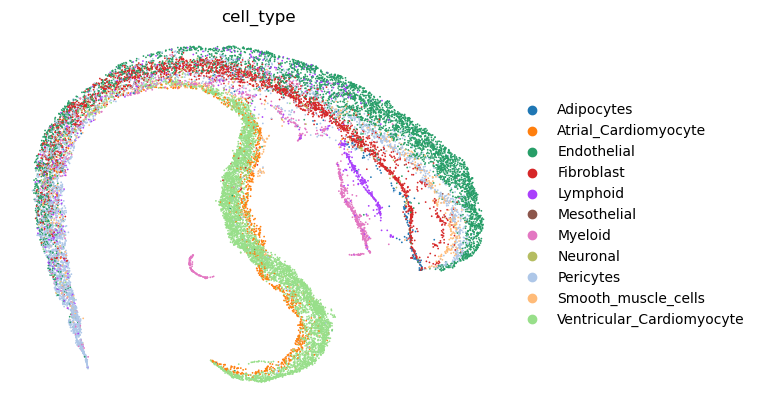

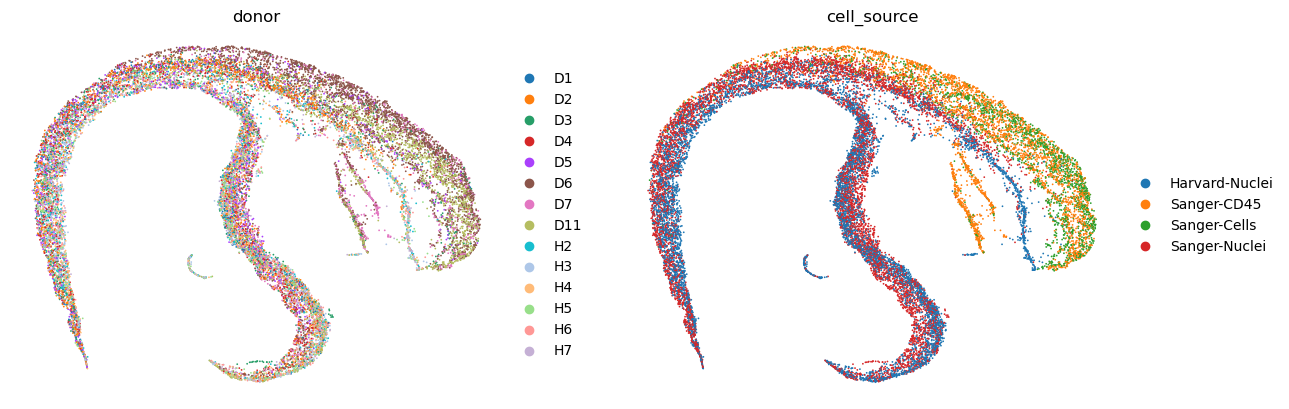

In [28]:
sc.pp.neighbors(adata, use_rep=CCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)